# Titanic: Machine Learning

## Exploration des données

Dans un premier temps, regardons l'allure du dateset:

In [1]:
import pandas as pd

passengers = pd.read_csv("train.csv")

In [2]:
passengers.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Il va falloir faire attention aux valeurs nulles pour les champs **Age**,**Cabin** et **Embarked**.

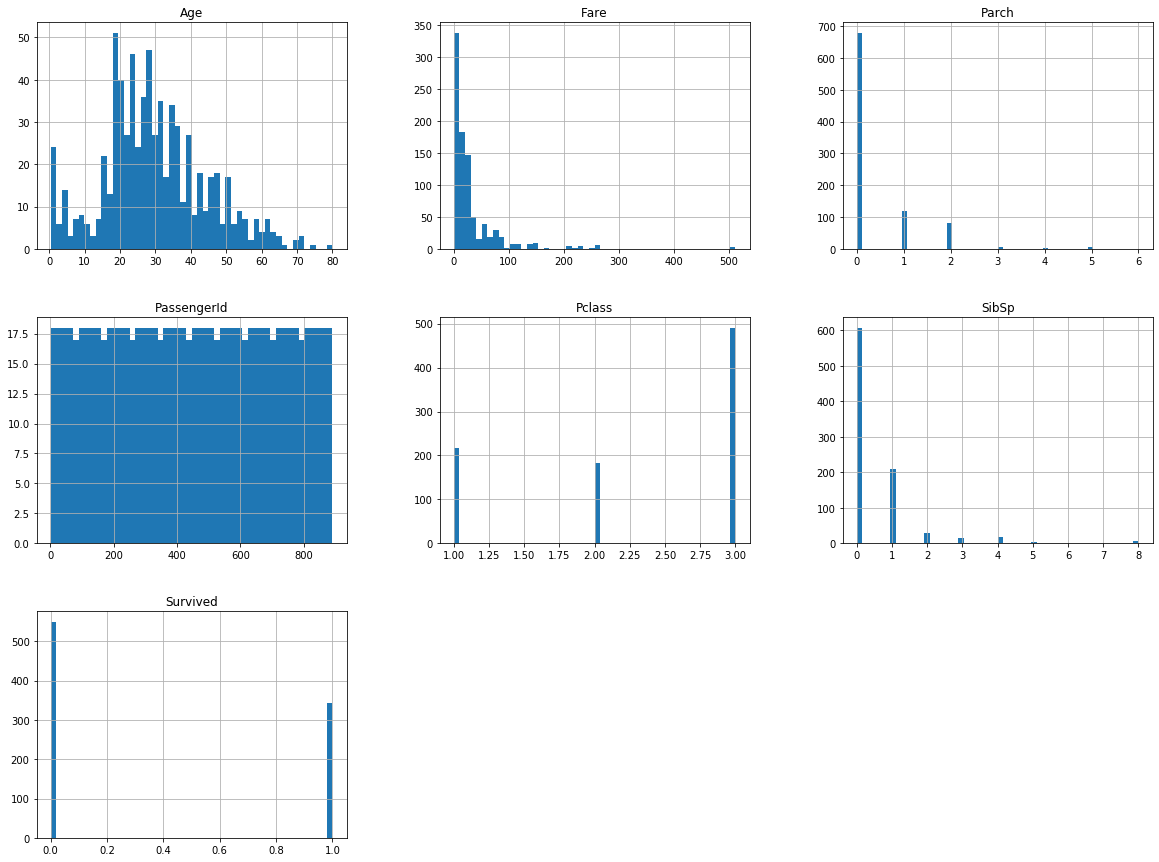

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

passengers.hist(bins=50, figsize=(20,15))
plt.show()

On remarque sur ces histogrammes que la majorité des passagers étaient en 3ème classe.    
De plus, comme l'a voulu l'histoire, la majorité des passagers sont morts dans la catastrophe.

#### Il pourrait être interessant de calculer le pourcentage de survivants par catégorie sociale:

In [5]:
nb_passengers_per_cat = passengers[["Pclass","Survived"]].groupby("Pclass").count()
nb_passengers_per_cat.rename(columns={"Survived": "nb_passengers"},inplace=True)
nb_survivors_per_cat = passengers[["Pclass","Survived"]].groupby("Pclass").sum()
percentage_survivors_per_cat = nb_survivors_per_cat["Survived"] / nb_passengers_per_cat["nb_passengers"]
percentage_survivors_per_cat.plot(kind='bar')

On observe que plus les passagers avaient un billet pour une classe élevée, plus leur chance de survie était grande.
L'attribut Pclass sera donc déterminant pour nos prédictions.

#### On peut également calculer le pourcentage de survivants par sexe:

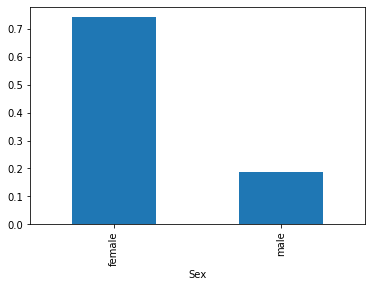

In [6]:
nb_passengers_per_sex = passengers[["Sex","Survived"]].groupby("Sex").count()
nb_passengers_per_sex.rename(columns={"Survived": "nb_passengers"},inplace=True)
nb_survivors_per_sex = passengers[["Sex","Survived"]].groupby("Sex").sum()
percentage_survivors_per_sex = nb_survivors_per_sex["Survived"] / nb_passengers_per_sex["nb_passengers"]
percentage_survivors_per_sex.plot(kind='bar')

On observe que les femmes avaient significativement plus de chance de survivre que les hommes, 70% de chance contre seulement 20%. 

In [7]:
passengers["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Sur la navire, il y avait une majorité d'hommes.

#### Correlation entre attributs:

In [8]:
passengers_vizu = passengers.copy()
passengers_vizu["Sex"].replace("female",0,inplace=True)
passengers_vizu["Sex"].replace("male",1,inplace=True)

corr_matrix = passengers_vizu.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

Sans surprise, on retrouve les relations observées précedemment: la survie est d'autant plus probable que la classe sociale est elevée ou que le sexe est féminin.
On remarque qu'un dernière attribut se démarque: Fare. Il semble que plus les gens ont payés leur billet cher, plus leur chance de survivre est elevée.

In [9]:
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Fare", "Age","Pclass","Sex"]
scatter_matrix(passengers_vizu[attributes], figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002184D30FC18>,
      dtype=object)

A cause des attributs discrets, la scatter matrix est assez peu lisible.
On peut toutefois remarquer que Age ne semble être correlé à aucun autre attribut.

## Selection des features

Dans un premier temps, nous allons garder les 4 attributs suivants: **Fare**,**Age**, **Pclass** et **Sex**.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline

# transform sex text into simple 0 or 1
class SexBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, binarize_sex = True): # no *args or **kargs
        self.binarize_sex = binarize_sex
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def binary(self, obj):
        if obj == "male":
            return 1
        else:
            return 0
    
    def transform(self, X, y=None):
        res = X.copy()
        if self.binarize_sex:
            res.loc[:,'Sex'] = res['Sex'].apply( self.binary )
        # /!\ Return panda date frame
        return res
    
#Select attributes and return them under numpy array format
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
predictors = ["Fare","Age","Pclass","Sex"]

predictors_pipeline = Pipeline([
    ("sex binarizer",SexBinarizer()),
    ("selector",DataFrameSelector(predictors)),
    ('imputer', SimpleImputer(strategy="median")), #replace null for age by the median
    ('std_scaler', MinMaxScaler())
])

passengers_prepared = predictors_pipeline.fit_transform(passengers)

Après cette étape de prépation, nous avons un numpy array avec uniquement les 4 features qui nous interessent, dans lesquels toutes les valeurs ont été normalisées et les valeurs nulles remplacées par la médiane.

Il ne nous reste plus qu'à les utiliser pour tenter de prédire les labels suivants, correspondant à la survie ou non du passager:

In [39]:
passengers_labels = passengers["Survived"].copy()

## Machine Learning

#### Random Forests

Pour commencer, essayons de prédire la survie des passagers avec l'algorithme Random Forests:

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10)

scores = cross_val_score(random_forest, passengers_prepared, passengers_labels,
 scoring="accuracy", cv=10)

In [50]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(scores)

Scores: [0.75555556 0.75555556 0.76404494 0.85393258 0.86516854 0.83146067
 0.84269663 0.7752809  0.83146067 0.875     ]
Mean: 0.8150156054931337
Standard deviation: 0.044925433301050775


Pour une première tentative, les résultats sont très convainquants. Avec cross-validation, on obtient la bonne prédiction **8 fois sur 10** en moyenne.

Avant de modifier les hyper-paramètres, tentons d'utiliser d'autres modèles.

#### Support Vector Machines

In [52]:
from sklearn.svm import SVC

svc = SVC(gamma="auto")

scores = cross_val_score(svc, passengers_prepared, passengers_labels,
 scoring="accuracy", cv=10)

display_scores(scores)

Scores: [0.81111111 0.78888889 0.7752809  0.84269663 0.79775281 0.7752809
 0.76404494 0.74157303 0.80898876 0.76136364]
Mean: 0.7866981613891727
Standard deviation: 0.027942239243488882


Les performances de l'algorithme Support Vector Machines sont légèrement en dessous de la méthode Random Forest, mais pas significativement.

#### Linear Discriminant Analysis

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()

scores = cross_val_score(lda, passengers_prepared, passengers_labels,
 scoring="accuracy", cv=10)

display_scores(scores)

Scores: [0.8        0.77777778 0.7752809  0.86516854 0.79775281 0.76404494
 0.7752809  0.74157303 0.80898876 0.77272727]
Mean: 0.78785949381455
Standard deviation: 0.03166234443162348


Les performances sont semblables à la méthode Support Vector Machines.

**Suite à cette première phase exploratoire, 
nous allons privilégier l'algorithme Random forest et voir s'il est possible d'ameliorer ses performances en jouant sur les hyper-paramètres.**

### choix des hyperparamètres optimaux

Pour tenter d'ameliorer les performances du modèle, nous allons jouer sur les paramètres suivants:
- **n_estimators** : Le nombre d'arbres produit par l'algorithme
- **max_features** : Le nombre de features considerées par chaque arbre
- **min_sample_leaf** : la taille du sample utilisé pour la construction de chaque arbre

Dans un premier temps, tentons une recherche exhaustive sur un nombre de valeurs restreint de ces paramètres:

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [10, 50, 100], 'max_features': [1, 2, 3, 4],
  'min_samples_leaf': [1,25,50]}
 ]

random_forest_opti = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_opti, param_grid, cv=5,scoring='accuracy',n_jobs=-1)
grid_search.fit(passengers_prepared, passengers_labels)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 10}
0.8148148148148148


On retombe sur la qualité de prédiction que nous permettait d'avoir les hyperparamètres par défaut.

In [69]:
from sklearn.model_selection import RandomizedSearchCV

full_param_grid = {'n_estimators': [10, 50, 100,200,500], 'max_features': [1, 2, 3, 4],
  'min_samples_leaf': [1,10,25,50,100]}

random_forest_opti_2 = RandomForestClassifier()
random_grid_search = RandomizedSearchCV(random_forest_opti_2, full_param_grid, n_iter=50,cv=5,scoring='accuracy',n_jobs=-1)
random_grid_search.fit(passengers_prepared, passengers_labels)
print(random_grid_search.best_params_)
print(random_grid_search.best_score_)

{'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 2}
0.819304152637486


Augmenter énormement le paramètre **n_estimators** permet un microscopique gain en précision, peu significatif.

### Analyse du modèle final

Regardons l'importance de chaque feature au sein du modèle final:

In [76]:
feature_importances = random_grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, predictors), reverse=True)

[(0.3358102952313264, 'Fare'),
 (0.2827346782174059, 'Age'),
 (0.28088176009324667, 'Sex'),
 (0.10057326645802109, 'Pclass')]

Comme nous l'avions observé pendant la phase d'exploration, les features **Fare** et **Sex** sont déterminantes.    
Alors que nous ne nous en étions par rendu compte, la feature **Age** semble être aussi essentielle.
Enfin, contrairement à ce que l'on pensait, la feature **Pclass** a été de moindre importance. Mais cela ne signifie pas nécessairement qu'elle est intrinsequement sans importance. En effet, **Pclass** est fortement correlé à **Fare** donc l'algorithme a peut être privilegié arbitrairement une feature sur l'autre.

## Prédictions sur le jeu de test

Maintenant que nous avons entrainé notre modèle, il ne nous reste plus qu'à réaliser les prédictions sur le jeu de test et à produire le csv à poster sur Kaggle.

Avant toute chose, il convient d'appliquer les transformations subies par le training set au test set:

In [79]:
pasg_test = pd.read_csv("test.csv")
pasg_test_prepared = predictors_pipeline.transform(pasg_test)

Cela étant fait, nous pouvons réaliser la prédiction:

In [82]:
final_model = random_grid_search.best_estimator_
final_predictions = final_model.predict(pasg_test_prepared)

Il ne reste plus qu'à construire le csv:

In [91]:
with open("result.csv",'w') as csv_res:
        csv_res.write("PassengerId,Survived\n")
        for passId,survivor in zip(pasg_test["PassengerId"],final_predictions):
            csv_res.write(str(passId))
            csv_res.write(",")
            csv_res.write(str(survivor))
            csv_res.write("\n")

Avec ces premières prédictions, on réussit à obtenir un score de 0.74162 sur Kaggle ! C'est un bon début, mais il est certainement possible de faire bien mieux en construisant de nouvelles features.